In [1]:
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn   
import pandas as pd
import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import shutil
import matplotlib.cm as cm
import matplotlib.pyplot as plt

df = pd.read_pickle(fr'C:\Users\achfr\OneDrive - University of Edinburgh\Compiled dataset\df_compiled_mothers_labelled_cyclefate.csv')
df_tracks= df.pivot(values=[
    'GrowthRateSize','GrowthRateLength','GrowthRateFeretMax','GrowthRateFeretMaxSliding',
    'InterdivisionTimes','DivisionRate','DivisionRate_filtered','TrackLength','TrackLength_filtered',
    'Size','SizeAtBirthSize','FeretMax','SizeAtBirthFeretMax','MaxLength','SpineLength','SizeAtBirthLength','SpineWidth',
    'MeanIntensity_mch','MeanIntensity_gfp','Maxgfp',
    'BacteriaLineage','NextDivisionFrame','PreviousDivisionFrame',
    'TrackHeadIndices','Prev','Next','Idx','Frame','Indices','PositionIdx','cellcycle_fate'], 
    index=['Position','ParentTrackHeadIndices','Medium','Treatment','RepeatID','RepeatDate','fate','DeathSubtype'],
    columns='Time')

In [ ]:
import importlib
import vrae.vrae

# Force reload the module
importlib.reload(vrae.vrae)

['glu' 'control' '2' '288']
train (57607, 72, 1)
test (699, 72, 1)


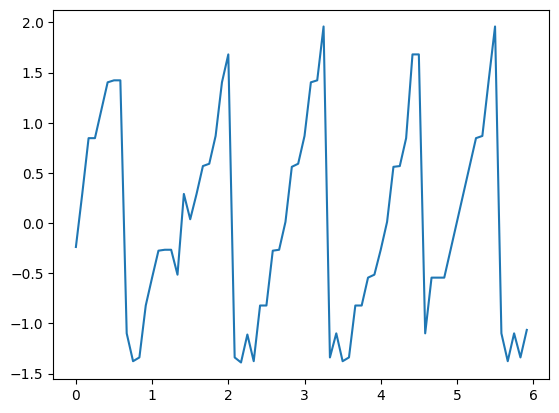

In [2]:
#### Creating dataset and splitting it into train and test sets then data augmentation
liste_x=[]
liste_y=[]

for exp_name in ['gly_control_1','gly_control_2','gly_control_3','glu_control_1','glu_control_2','gluaa_control_1','gluaa_control_2']:

    medium,treatment,replicate = exp_name.split('_')

    frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
    size_array = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
    cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])

    for i in range(size_array.shape[0]):
        size_serie =  size_array[i]
        ##fill nans missing timepoints with the mean of the previous and next timepoints
        for j in range(1,len(size_serie)-1):
            if np.isnan(size_serie[j]):
                size_serie[j] = np.mean([size_serie[j-1],size_serie[j+1]])
        cyclefate_serie = cyclefate_array[i]
        ##fill nans missing timepoints with the next fate timepoint
        for j in range(len(cyclefate_serie)-1):
            if cyclefate_serie[j] == 'nan':
                cyclefate_serie[j] = cyclefate_serie[j+1]

        t_death = len(cyclefate_serie)
        if np.where(cyclefate_serie != 'alive')[0].shape[0] > 0:
            t_death = np.where(cyclefate_serie != 'alive')[0][0]

        usable_data = size_serie[:min(t_death,288)]

        if len(usable_data) > 72:
            liste_x.append(usable_data)
            liste_y.append((medium,treatment,replicate,t_death))

X_train_preaug, X_test_preaug, y_train_preaug, y_test_preaug = train_test_split(liste_x, liste_y, test_size=0.1, random_state=42, shuffle=True)

##### in X_train we change eahc sequence to series of size 72 with a roling window of 12
liste_x_train = []
liste_y_train = []
for i in range(len(X_train_preaug)):
    usable_data = X_train_preaug[i]
    for j in range(0, len(usable_data) - 72 + 1, 6):
        liste_x_train.append(usable_data[j:j+72])
        liste_y_train.append(y_train_preaug[i])
X_train = TimeSeriesScalerMeanVariance().fit_transform(np.array(liste_x_train))
y_train = np.array(liste_y_train)

# In X_test we cut each sequence into unique 72-long sequences
liste_x_test = []
liste_y_test = []
for i in range(len(X_test_preaug)):
    usable_data = X_test_preaug[i]
    for j in range(0, len(usable_data) - 72 + 1, 72):
        liste_x_test.append(usable_data[j:j + 72])
        liste_y_test.append(y_test_preaug[i])
X_test = TimeSeriesScalerMeanVariance().fit_transform(np.array(liste_x_test))
y_test = np.array(liste_y_test)

r = np.random.randint(0,X_train.shape[0])
serie = X_train[r]
print(y_train[r])
plt.plot(np.arange(0,len(serie))/12,serie)

# num_elements_to_duplicate = 200 - X_test.shape[0] # Calculate the number of elements to duplicate
# indices_to_duplicate = np.random.choice(X_test.shape[0], num_elements_to_duplicate, replace=True)# Randomly select indices to duplicate
# X_test_augmented = np.concatenate((X_test, X_test[indices_to_duplicate]), axis=0)# Duplicate the selected elements
# test_dataset_augmented = TensorDataset(torch.from_numpy(X_test_augmented))
print('train', X_train.shape)
print('test', X_test.shape)

In [ ]:
# # # train cell
# import time
# t0 = time.time()

# train_dataset = TensorDataset(torch.from_numpy(X_train).to('cuda'))
# test_dataset = TensorDataset(torch.from_numpy(X_test))

# sequence_length = X_train.shape[1]
# number_of_features = X_train.shape[2]

# dload = './model_dir_mm' #download directory
# hidden_size = 90
# hidden_layer_depth = 2
# batch_size = 200
# learning_rate = 0.001 # 0.0005
# n_epochs = 200
# dropout_rate = 0.2
# optimizer = 'Adam' # options: ADAM, SGD
# cuda = True # options: True, False
# print_every=1000
# clip = True # options: True, False
# max_grad_norm=5
# loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
# block = 'LSTM' # options: LSTM, GRU


# for latent_length in range(20,3-1,-1):
#     print('latent_length\t',latent_length,'\t elapsed time\t',(time.time()-t0)/60,' minutes\t',(time.time()-t0)/3600.0,' hours')

#     vrae = VRAE(sequence_length=sequence_length,
#                 number_of_features = number_of_features,
#                 hidden_size = hidden_size, 
#                 hidden_layer_depth = hidden_layer_depth,
#                 latent_length = latent_length,
#                 batch_size = batch_size,
#                 learning_rate = learning_rate,
#                 n_epochs = n_epochs,
#                 dropout_rate = dropout_rate,
#                 optimizer = optimizer, 
#                 cuda = cuda,
#                 print_every=print_every, 
#                 clip=clip, 
#                 max_grad_norm=max_grad_norm,
#                 loss = loss,
#                 block = block,
#                 dload = dload)


#     vrae.fit(train_dataset, save=True)
#     file = open(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\print.txt').readlines()
#     losses = []
#     for line in file:
#         if 'Average loss' in line:
#             losses.append(float(line.split(' ')[-1][:-2]))
#     # plt.plot(losses)

#     shutil.move(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\model.pth', fr'C:\Users\achfr\timeseries-clustering-vae\latent_results\model_{latent_length}.pth')
#     np.save(fr'C:\Users\achfr\timeseries-clustering-vae\latent_results\losses_{latent_length}.npy', losses)

In [8]:
# # train cell with test
import time
from vrae.vrae import VRAE
from vrae.utils import *
t0 = time.time()

train_dataset = TensorDataset(torch.from_numpy(X_train).to('cuda'))
test_dataset = TensorDataset(torch.from_numpy(X_test))

sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

dload = './model_dir_mm' #download directory
hidden_size = 90
hidden_layer_depth = 2
batch_size = 200
learning_rate = 0.001 # 0.0005
n_epochs = 200
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=1000
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU


for latent_length in range(4,2-1,-1):
    print('latent_length\t',latent_length,'\t elapsed time\t',(time.time()-t0)/60,' minutes\t',(time.time()-t0)/3600.0,' hours')

    vrae = VRAE(sequence_length=sequence_length,
                number_of_features = number_of_features,
                hidden_size = hidden_size, 
                hidden_layer_depth = hidden_layer_depth,
                latent_length = latent_length,
                batch_size = batch_size,
                learning_rate = learning_rate,
                n_epochs = n_epochs,
                dropout_rate = dropout_rate,
                optimizer = optimizer, 
                cuda = cuda,
                print_every=print_every, 
                clip=clip, 
                max_grad_norm=max_grad_norm,
                loss = loss,
                block = block,
                dload = dload)

    vrae.fit(train_dataset, test_dataset, save=True)

    file = open(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\print.txt').readlines()
    train_losses = []
    test_losses = []
    for line in file:
        if 'Average loss' in line:
            train_losses.append(float(line.split(' ')[-2]))
            test_losses.append(float(line.split(' ')[-1][:-2]))
            print(float(line.split(' ')[-2]),float(line.split(' ')[-1][:-2]))

    shutil.move(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\model.pth', fr'C:\Users\achfr\timeseries-clustering-vae\latent_results_test\model_{latent_length}.pth')
    np.save(fr'C:\Users\achfr\timeseries-clustering-vae\latent_results_test\train_losses_{latent_length}.npy', train_losses)
    np.save(fr'C:\Users\achfr\timeseries-clustering-vae\latent_results_test\test_losses_{latent_length}.npy', test_losses)

latent_length	 4 	 elapsed time	 0.004742101828257243  minutes	 7.903503047095405e-05  hours
Epoch: 0
Average loss: 13382.6018
Epoch: 1
Average loss: 10871.6427
Epoch: 2
Average loss: 9994.4329
Epoch: 3
Average loss: 9050.9747
Epoch: 4
Average loss: 8253.9031
Epoch: 5
Average loss: 7601.1591
Epoch: 6
Average loss: 7470.3788
Epoch: 7
Average loss: 7146.0738
Epoch: 8
Average loss: 7348.3929
Epoch: 9
Average loss: 6604.6666
Epoch: 10
Average loss: 6611.1526
Epoch: 11
Average loss: 6440.3243
Epoch: 12
Average loss: 6490.6778
Epoch: 13
Average loss: 6336.0914
Epoch: 14
Average loss: 6090.6056
Epoch: 15
Average loss: 5988.2801
Epoch: 16
Average loss: 5931.0935
Epoch: 17
Average loss: 6086.8517
Epoch: 18
Average loss: 5857.4941
Epoch: 19
Average loss: 5689.0552
Epoch: 20
Average loss: 5568.1210
Epoch: 21
Average loss: 5644.7012
Epoch: 22
Average loss: 5437.5821
Epoch: 23
Average loss: 5334.9035
Epoch: 24
Average loss: 5149.5452
Epoch: 25
Average loss: 5116.3017
Epoch: 26
Average loss: 5070.26

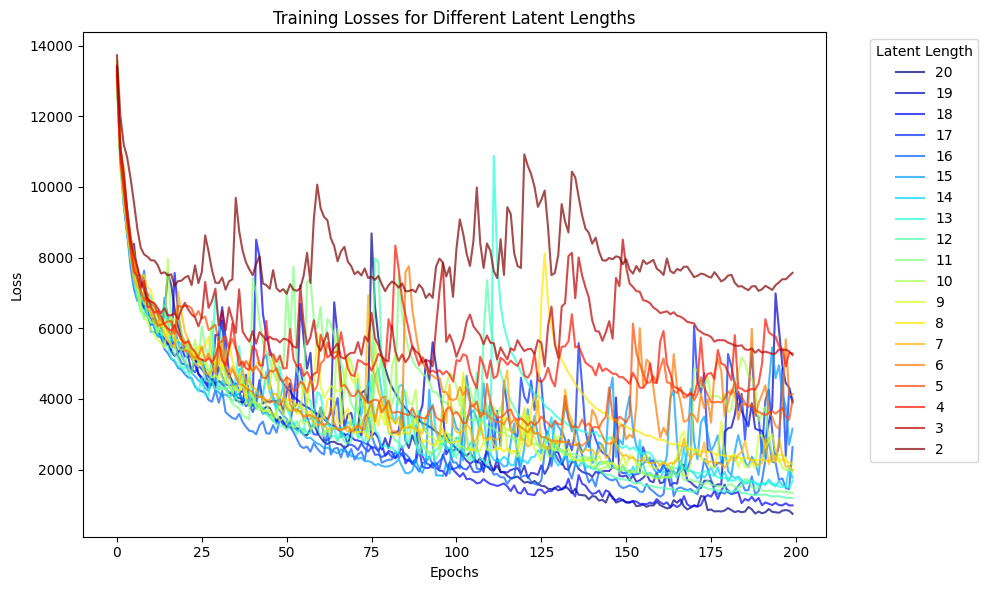

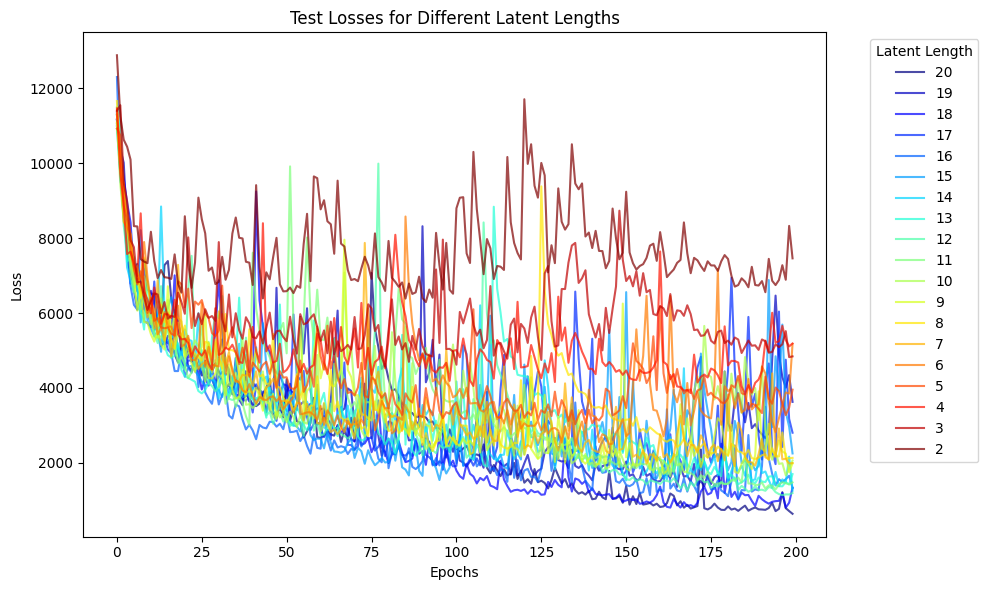

In [10]:
### print losses graph 
losses_list = []
latent_lengths = range(20, 2-1, -1)
colors = cm.jet(np.linspace(0, 1, len(latent_lengths))) 
plt.figure(figsize=(10, 6))
for i, latent_length in enumerate(latent_lengths):
    lossesx = np.load(fr'C:\Users\achfr\timeseries-clustering-vae\latent_results_test\train_losses_{latent_length}.npy')
    losses_list.append(lossesx)
    plt.plot(losses_list[-1], label=latent_length, color=colors[i], alpha=0.7)
plt.legend(title='Latent Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses for Different Latent Lengths')
plt.tight_layout()
plt.show()

losses_list = []
latent_lengths = range(20, 2-1, -1)
colors = cm.jet(np.linspace(0, 1, len(latent_lengths))) 
plt.figure(figsize=(10, 6))
for i, latent_length in enumerate(latent_lengths):
    lossesx = np.load(fr'C:\Users\achfr\timeseries-clustering-vae\latent_results_test\test_losses_{latent_length}.npy')
    losses_list.append(lossesx)
    plt.plot(losses_list[-1], label=latent_length, color=colors[i], alpha=0.7)
plt.legend(title='Latent Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Losses for Different Latent Lengths')
plt.tight_layout()
plt.show()

In [ ]:
## old import and test cell

# sequence_length = X_train.shape[1]
# number_of_features = X_train.shape[2]
# dload = './model_dir_mm' #download directory
# hidden_size = 90
# hidden_layer_depth = 2
# batch_size = 200
# learning_rate = 0.001 # 0.0005
# n_epochs = 200
# dropout_rate = 0.2
# optimizer = 'Adam' # options: ADAM, SGD
# cuda = True # options: True, False
# print_every=1000
# clip = True # options: True, False
# max_grad_norm=5
# loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
# block = 'LSTM' # options: LSTM, GRU

# loss_fun = nn.MSELoss(reduction='sum')

# test_losses = []
# for latent_length in range(20,3-1,-1):
#     vrae = VRAE(sequence_length=sequence_length,
#                 number_of_features = number_of_features,
#                 hidden_size = hidden_size, 
#                 hidden_layer_depth = hidden_layer_depth,
#                 latent_length = latent_length,
#                 batch_size = batch_size,
#                 learning_rate = learning_rate,
#                 n_epochs = n_epochs,
#                 dropout_rate = dropout_rate,
#                 optimizer = optimizer, 
#                 cuda = cuda,
#                 print_every=print_every, 
#                 clip=clip, 
#                 max_grad_norm=max_grad_norm,
#                 loss = loss,
#                 block = block,
#                 dload = dload)
#     vrae.load(fr'C:\Users\achfr\timeseries-clustering-vae\latent_results\model_{latent_length}.pth')

#     vrae.eval()
#     testseq = test_dataset_augmented[:batch_size][0].float()
#     testseq2 = testseq.permute(1, 0, 2).cuda()
#     outp = vrae.forward(testseq2)
#     test_losses.append(loss_fun(testseq2,outp[0]).cpu().detach().numpy())


# plt.figure(figsize=(10, 6))
# plt.plot(range(20,3-1,-1),test_losses, label = 'Final test loss', marker = 'x')
# plt.plot(range(20,3-1,-1),[i[-1] for i in losses_list], label = 'Final train loss',marker = '+')
# plt.xticks(range(3,21))
# plt.xlabel('Latent length')
# plt.ylabel('MSE loss')
# plt.legend()


# plt.figure(figsize=(10, 6))
# plt.plot(range(20,3-1,-1),test_losses, label = 'Final test loss', marker = 'x')
# plt.plot(range(20,3-1,-1),[np.min(i) for i in losses_list], label = 'Minimum train loss',marker = '+')
# plt.xticks(range(3,21))
# plt.xlabel('Latent length')
# plt.ylabel('MSE loss')
# plt.legend()
# a=1

In [ ]:

# Assuming vrae is your model and test_dataset is your dataset
vrae.eval()

# Define the loss function
criterion = nn.MSELoss(reduction='sum')

# Initialize variables to store the total loss and the number of batches
total_loss = 0
num_batches = 0

# Define the batch size
batch_size = 200  # Adjust the batch size as needed

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Iterate through the test dataset in batches
for batch in test_loader:
    testseq = batch[0].float()
    testseq2 = testseq.permute(1, 0, 2).cuda()
    outp = vrae.forward(testseq2) # Forward pass
    batch_loss = criterion(testseq2, outp[0])# Compute the loss for the current batch
    total_loss += batch_loss.item()# Accumulate the total loss
    num_batches += 1
mean_loss = total_loss / num_batches


print(f'Mean loss over all batches: {mean_loss}')

# Optionally, plot a random sequence from the test dataset
k = np.random.randint(0, batch_size)
input_seq = testseq2[:, k, :].cpu().detach().numpy()
output_seq = outp[0][:, k, :].cpu().detach().numpy()

plt.plot(input_seq, label='input')
plt.plot(output_seq, label='output')
plt.legend()
plt.show()

In [ ]:
input_seq.shape

In [ ]:
5000/60
83/24